In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import numpy as np
import os
import sys

In [77]:
ROOT_DIR = os.path.abspath("__file__" + "/../../")
sys.path.insert(0, f"{ROOT_DIR}")

In [117]:
spin_j = 6

env_name = f"single vertex spinfoam/j={float(spin_j)}"
batch_size = 16
n_iterations = int(3e3)

vertex = np.load(f"{ROOT_DIR}/data/EPRL_vertices/Python/Dl_20/vertex_j_{float(spin_j)}.npz")
sq_ampl = vertex**2
grid_rewards = sq_ampl / np.sum(sq_ampl)

# Generate Data

In [118]:
from src.MCMC.batched_mcmc import MCMCRunner

mcmc = MCMCRunner(grid_rewards=grid_rewards)
mcmc_chains, _ = mcmc.run_mcmc_chains(
    batch_size=batch_size, n_iterations=n_iterations, generated_data_dir=f"{ROOT_DIR}/jared_data/MCMC/{env_name}"
)

100%|██████████| 3000/3000 [00:01<00:00, 2849.72it/s]


In [ ]:
from src.grid_environments.base import BaseGrid
from src.trainers.trainer import train_gfn

loss_params = {
    "weighing": "geometric_within",
    "lamda": 0.9,
}
replay_params = {
    "capacity": 1000,
    "fraction_of_samples_from_top": 0.5,
    "top_and_bottom_fraction": 0.1,
    "max_fraction_offline": 0.5,
}
nn_params = {
    "hidden_dim": 512,
    "n_hidden_layers": 2,
    "activation_fn": "relu",
}

device_str = "cpu" # cpu or cuda (torchgfn has some issues with gpu)

terminal_states, _ = train_gfn(
    env=BaseGrid(grid_rewards=grid_rewards, device_str=device_str),
    generated_data_dir=f"{ROOT_DIR}/jared_data/GFN/{env_name}", # need better way to label folders
    batch_size=batch_size,
    n_iterations=n_iterations,
    learning_rate=0.001,
    exploration_rate=0.0, # (faster if set to 0)
    policy="sa",
    forward_looking=True,
    loss_params=loss_params,
    replay_params=None, # replay_params or None (faster if None)
    nn_params=nn_params,
)

100%|█████████▉| 2985/3000 [03:50<00:01, 12.80it/s]

# Analyze

In [102]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [103]:
def plot_observable_expectation_values(
    empirical_distributions, n_samples_used, spin_j, ax, label
):
    intertwiners = np.arange(int(2*spin_j + 1))
    cos_angle = intertwiners*(intertwiners+1)/(2*spin_j*(spin_j+1)) - 1

    reduced_distr_over_t = np.sum(empirical_distributions, axis=(2, 3, 4, 5))
    mean_cos_angles = np.sum(reduced_distr_over_t*cos_angle, axis=1)

    ax.scatter(n_samples_used, mean_cos_angles, label=label)
    ax.hlines(-0.33333, n_samples_used[0], n_samples_used[-1], colors='k', linestyles='dashed')
    ax.set_xlabel("n_samples in distribution")
    ax.set_ylabel(r"<cos $\theta$>")
    ax.set_ylim(-0.5, -0.1)
    ax.legend()

In [104]:
def get_distributions_over_time(grid_positions, grid_len, every_n_iterations=100):
    n_iterations, _, grid_dim = grid_positions.shape

    counts = np.zeros(shape=(grid_len, )*grid_dim)
    n_samples = 0
    empirical_distributions_over_time = []
    n_samples_used_over_time = []
    for i in range(0, n_iterations, every_n_iterations):
        states = np.concatenate(grid_positions[i:i+every_n_iterations])

        n_samples += states.shape[0]
        np.add.at(counts, tuple(states.T), 1)
        
        empirical_distributions_over_time.append(counts/n_samples)
        n_samples_used_over_time.append(n_samples)
    empirical_distributions_over_time = np.stack(empirical_distributions_over_time)
    return empirical_distributions_over_time, n_samples_used_over_time

In [105]:
def plot_l1_errors(
    empirical_distributions_over_time, expected_distribution, n_samples_used, ax, label
):
    l1_errors = np.abs(empirical_distributions_over_time - expected_distribution)
    
    grid_axes = empirical_distributions_over_time.ndim
    ave_error_over_time = np.mean(l1_errors, axis=tuple(range(1, grid_axes)))
    ax.scatter(n_samples_used, ave_error_over_time, label=label)
    ax.set_xlabel("n_samples in distribution")
    ax.set_ylabel(r"Average Distribution Error")
    ax.legend()

In [106]:
def plot_log_empirical_vs_log_expected(empirical, expected, ax, label):
    log_empirical = np.clip(np.log(empirical.ravel()), a_min=-50, a_max=None)
    log_expected = np.log(expected.ravel())
    
    expected_range = [log_expected.min(), log_expected.max()]
    ax.scatter(log_empirical, log_expected, label=label)
    ax.plot(expected_range, expected_range, ls="--", color="r")
    ax.set_xlabel("log P")
    ax.set_ylabel(r"log $A^2$")
    ax.legend()

In [107]:
def plot_observable_expectation_values_window(
    empirical_distributions, iterations, spin_j, ax, label
):
    intertwiners = np.arange(int(2*spin_j + 1))
    cos_angle = intertwiners*(intertwiners+1)/(2*spin_j*(spin_j+1)) - 1

    reduced_distr_over_t = np.sum(empirical_distributions, axis=tuple(range(2, empirical_distributions.ndim)))
    mean_cos_angles = np.sum(reduced_distr_over_t*cos_angle, axis=1)

    ax.scatter(iterations, mean_cos_angles, label=label)
    ax.hlines(-0.33333, iterations[0], iterations[-1], colors='k', linestyles='dashed')
    ax.set_xlabel("iteration number")
    ax.set_ylabel(r"<cos $\theta$>")
    ax.set_ylim(-0.5, -0.1)
    ax.legend()

In [108]:
def plot_l1_errors_window(
    empirical_distributions_over_time, expected_distribution, iterations, ax, label
):
    l1_errors = np.abs(empirical_distributions_over_time - expected_distribution)
    
    grid_axes = empirical_distributions_over_time.ndim
    ave_error_over_time = np.mean(l1_errors, axis=tuple(range(1, grid_axes)))
    ax.scatter(iterations, ave_error_over_time, label=label)
    ax.set_xlabel("iteration number")
    ax.set_ylabel("Average Distribution Error")
    ax.legend()

In [109]:
def get_distributions_over_time_window(grid_positions, grid_len, window_size=100, every_n_iterations=100):
    n_iterations, _, grid_dim = grid_positions.shape

    # counts = np.zeros(shape=(grid_len, )*grid_dim)
    empirical_distributions_over_time = []
    iterations = []
    
    w_idx, w_mod = divmod(window_size, 2)
    
    for i in range(0, n_iterations, every_n_iterations):
        left_idx = max(0, i - w_idx)
        right_idx = min(n_iterations, i + w_idx + w_mod)
        if left_idx == 0:
            right_idx = window_size
        if right_idx == n_iterations:
            left_idx = n_iterations - window_size

        states = np.concatenate(grid_positions[left_idx:right_idx])
        num_samples = states.shape[0]
        
        counts = np.zeros(shape=(grid_len, )*grid_dim)
        np.add.at(counts, tuple(states.T), 1)
        empirical_distributions_over_time.append(counts/num_samples)
        iterations.append(i)

    empirical_distributions_over_time = np.stack(empirical_distributions_over_time)
    return empirical_distributions_over_time, iterations

In [110]:
def get_distributions_over_time_flattened(grid_len, distributions_over_time, iteration = -1):
    distributions_over_time_flattened = []
    grid_coordinates = []
    if distributions_over_time.ndim == 6:
        distributions_over_time = distributions_over_time[iteration, :, :, :, :, :]
    for i1 in range(grid_len):
        for i2 in range(grid_len):
            for i3 in range(grid_len):
                for i4 in range(grid_len):
                    for i5 in range(grid_len):
                        distributions_over_time_flattened.append(distributions_over_time[i1, i2, i3, i4, i5])
                       
                        grid_coordinates.append(np.array([i1, i2, i3, i4, i5]))

    return grid_coordinates, np.array(distributions_over_time_flattened)

In [111]:
window_size = 10000

grid_len = int(2*spin_j + 1)

In [112]:
mcmc_chains = np.load(f"{ROOT_DIR}/jared_data/MCMC/single vertex spinfoam/j={float(spin_j)}/mcmc_chains.npy")

mcmc_distributions_over_time, mcmc_n_t = get_distributions_over_time(
    mcmc_chains, grid_len, every_n_iterations=100, 
)

mcmc_distributions_over_time_window, mcmc_iterations = get_distributions_over_time_window(
    mcmc_chains, grid_len, window_size=window_size, 
)

In [113]:
gfn_states = np.load(f"{ROOT_DIR}/jared_data/GFN/single vertex spinfoam/j={float(spin_j)}/terminal_states.npy")

gfn_distributions_over_time, gfn_n_t = get_distributions_over_time(
    gfn_states, grid_len, every_n_iterations=100
)

gfn_distributions_over_time_window, gfn_iterations = get_distributions_over_time_window(
    gfn_states, grid_len, window_size=window_size
)

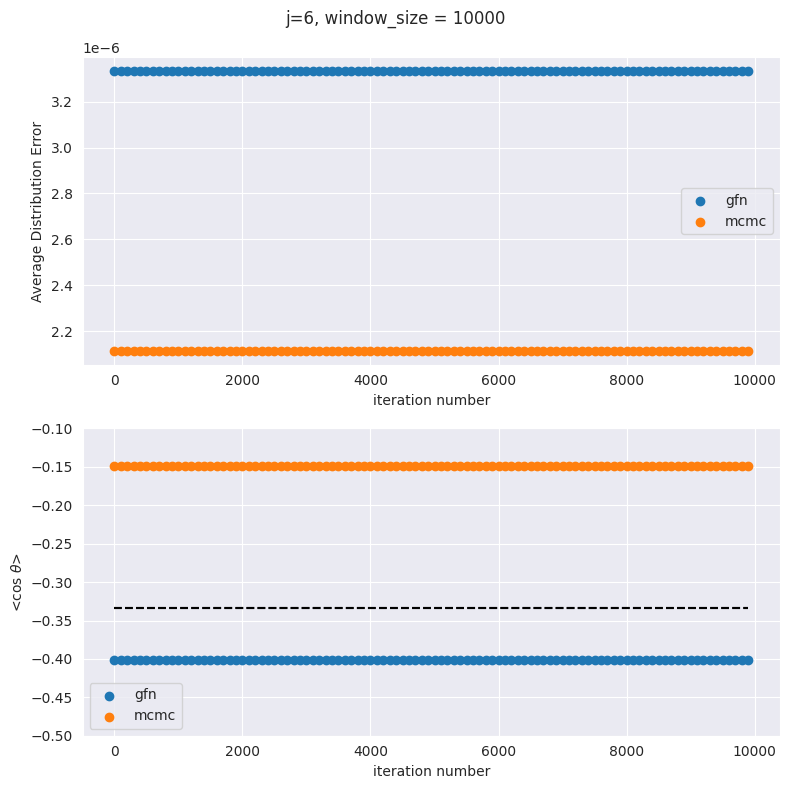

In [114]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

fig.suptitle(f"j={spin_j}, {window_size = }")

plot_l1_errors_window(
    gfn_distributions_over_time_window, grid_rewards, gfn_iterations, ax[0], "gfn"
)
plot_l1_errors_window(
    mcmc_distributions_over_time_window, grid_rewards, mcmc_iterations, ax[0], "mcmc"
)

plot_observable_expectation_values_window(
    gfn_distributions_over_time_window, gfn_iterations, spin_j, ax[1], "gfn"
)
plot_observable_expectation_values_window(
    mcmc_distributions_over_time_window, mcmc_iterations, spin_j, ax[1], "mcmc"
)

# plot_log_empirical_vs_log_expected(
#     gfn_distributions_over_time_window[-1], grid_rewards, ax[2], "gfn"
# )

plt.tight_layout()

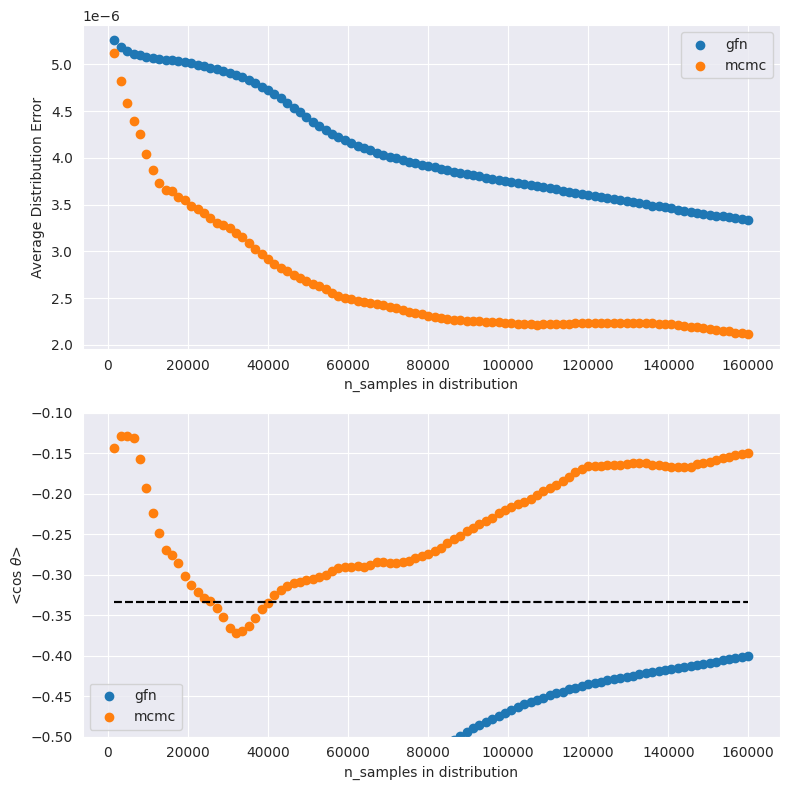

In [115]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

plot_l1_errors(
    gfn_distributions_over_time, grid_rewards, gfn_n_t, ax[0], "gfn"
)
plot_l1_errors(
    mcmc_distributions_over_time, grid_rewards, mcmc_n_t, ax[0], "mcmc"
)

plot_observable_expectation_values(
    gfn_distributions_over_time, gfn_n_t, spin_j, ax[1], "gfn"
)
plot_observable_expectation_values(
    mcmc_distributions_over_time, mcmc_n_t, spin_j, ax[1], "mcmc"
)

# plot_log_empirical_vs_log_expected(
#     gfn_distributions_over_time[-1], grid_rewards, ax[2], "gfn"
# )

plt.tight_layout()

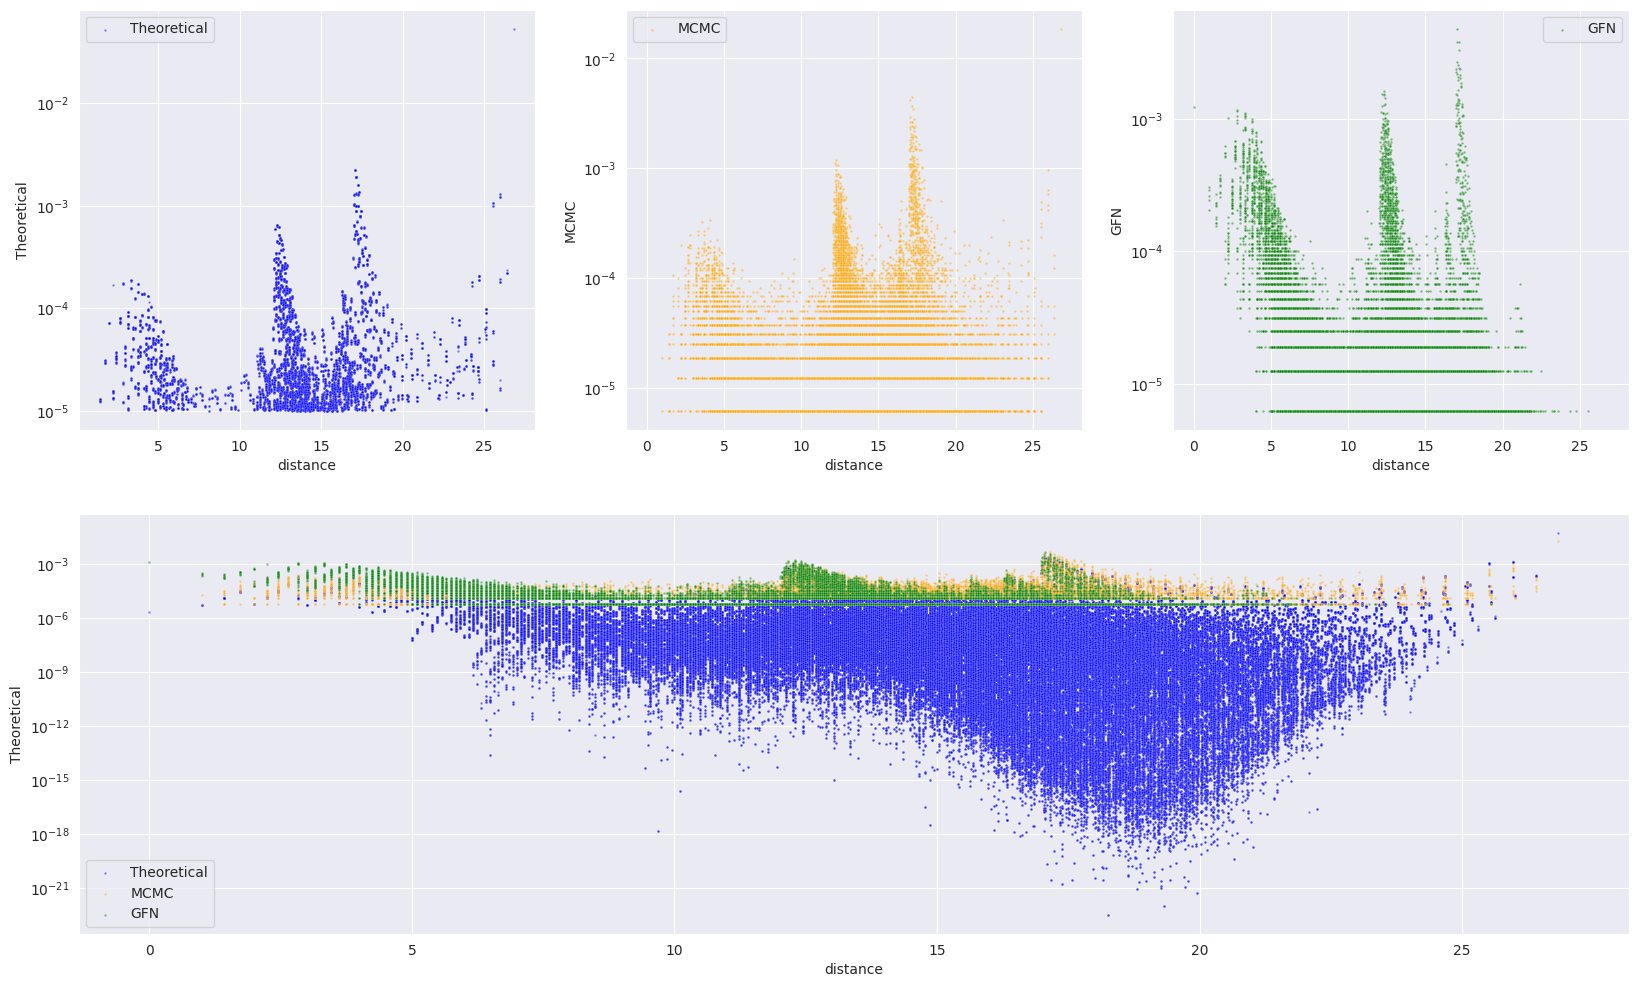

In [116]:
# Create a 2D array of the grid coordinates and the respective rewards, flattened.
grid_coordinates_list, gfn_distributions_over_time_flattened = get_distributions_over_time_flattened(
    grid_len, gfn_distributions_over_time
)

grid_coordinates_list, mcmc_distributions_over_time_flattened = get_distributions_over_time_flattened(
    grid_len, mcmc_distributions_over_time
)

_, theoretical_distributions_over_time_flattened = get_distributions_over_time_flattened(
    grid_len, grid_rewards
)

df = pd.DataFrame(
    {
        "Coordinates": grid_coordinates_list,
        "Theoretical": theoretical_distributions_over_time_flattened,
        "MCMC": mcmc_distributions_over_time_flattened,
        "GFN": gfn_distributions_over_time_flattened
     }
)

df["distance"] = df["Coordinates"].apply(lambda x: np.sqrt(sum(x**2)))
s = 3
alpha = 0.5

sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 12))

gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, :])

ax1.set_yscale("log")
ax2.set_yscale("log")
ax3.set_yscale("log")
ax4.set_yscale("log")

sns.scatterplot(x=df["distance"], y=df[df.Theoretical > 10**(-5)].Theoretical, label="Theoretical", s=s, alpha=alpha, ax=ax1, color="blue")
sns.scatterplot(x=df["distance"], y=df["MCMC"], label="MCMC", s=s, alpha=alpha, ax=ax2, color="orange")
sns.scatterplot(x=df["distance"], y=df["GFN"], label="GFN", s=s, alpha=alpha, ax=ax3, color="green")

sns.scatterplot(x=df["distance"], y=df["Theoretical"], label="Theoretical", s=s, alpha=alpha, ax=ax4, color="blue")
sns.scatterplot(x=df["distance"], y=df["MCMC"], label="MCMC", s=s, alpha=alpha, ax=ax4, color="orange")
sns.scatterplot(x=df["distance"], y=df["GFN"], label="GFN", s=s, alpha=alpha, ax=ax4, color="green")

plt.show()

In [72]:
import torch

In [8]:
2 ** torch.arange(5 - 1, -1, -1)

tensor([16,  8,  4,  2,  1])

In [7]:
digits = torch.arange(3)
all_states = torch.cartesian_prod(*[digits] * 2)
all_states

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]])

In [17]:
terminating_states = [all_states if 2 in list else None for list in all_states]

In [19]:
terminating_states = [element for element in terminating_states if element is not None]

In [21]:
terminating_states = torch.cat(terminating_states)

In [29]:
terminating_states.size()

torch.Size([45, 2])